## Transfer Learning with TensorFlow (Feature Extraction/ Fine-Tuning) - Part 2

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from helper_function import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

### 1. Data preparation

In [2]:
train_dir_path_10_10 = "image_data/10_food_classes_10_percent/train/"
test_dir_path_10_10 = "image_data/10_food_classes_10_percent/test/"
train_dir_path_10_1 = "image_data/10_food_classes_1_percent/train/"
test_dir_path_10_1 = "image_data/10_food_classes_1_percent/test/"

In [3]:
### Walk thro image data path

walk_through_dir("image_data/10_food_classes_10_percent")

There are 2 directories and 0 images in 'image_data/10_food_classes_10_percent'.
There are 10 directories and 0 images in 'image_data/10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\hamburger'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\ice_cream'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\pizza'.
There are 0 directories and 250 images in 'image_data/10_food_classes_10_percent\test\ramen'.
There are 0 directories and 250 images in 

In [4]:
img_size = (224, 224)

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_path_10_10,
    image_size = img_size, label_mode = "categorical", batch_size = 32)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir_path_10_10,
    image_size = img_size, label_mode = "categorical")

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir_path_10_1,
    image_size = img_size, label_mode = "categorical", batch_size = 32)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir_path_10_1,
    image_size = img_size, label_mode = "categorical")

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [5]:
### Check its type and shape

train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [6]:
### Check class names

train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [7]:
### Review an example batch of data

for images, labels in train_data_10_percent.take(1):
    print(images, labels)

tf.Tensor(
[[[[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [5.55664444e+01 3.72092361e+01 3.24948196e+01]
   [5.54745102e+01 2.74949760e+01 2.14491138e+01]
   [5.49995804e+01 4.70305862e+01 4.71581497e+01]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [6.12042732e+01 3.90306091e+01 3.51734428e+01]
   [5.67652626e+01 3.23469772e+01 2.56225243e+01]
   [5.03670120e+01 4.10713577e+01 4.14285355e+01]]

  [[1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   [1.00000000e+00 1.00000000e+00 1.00000000e+00]
   ...
   [6.54541702e+01 3.93162155e+01 3.48111420e+01]
   [5.33570518e+01 3.40714417e+01 2.73571701e+01]
   [4.94592628e+01 3.77805710e+01 3.76888771e+01]]

  ...

  [[1.82091808e+01 1.83622494e+01 1.64387817e+01]
   [2

### 2. Model building
First model (EfficientNetV2B0) - Transfer learning (feature extraction) on 10% of 10 classes food data

In [8]:
### Set include_top = False because we have custom input layer
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

### Freeze to keep pre-learned pattern
base_model.trainable = False

### Create input layer
input_layer = tf.keras.layers.Input(shape = (224, 224, 3), name = "input_layer")

x = base_model(input_layer)
# print(x.shape)

x = tf.keras.layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
# print(x.shape)

### Create output layer
output_layer = tf.keras.layers.Dense(10, activation = "softmax", name = "output_layer")(x)

### Combine the input layer and output layer into single model
first_model = tf.keras.Model(input_layer, output_layer)

### Compiling the model
first_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

first_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

In [9]:
### Check EfficientNetV2B0 summary

base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

 block3b_expand_activation   (None, None, None, 192)      0         ['block3b_expand_bn[0][0]']   
 (Activation)                                                                                     
                                                                                                  
 block3b_project_conv (Conv  (None, None, None, 48)       9216      ['block3b_expand_activation[0]
 2D)                                                                [0]']                         
                                                                                                  
 block3b_project_bn (BatchN  (None, None, None, 48)       192       ['block3b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block3b_drop (Dropout)      (None, None, None, 48)       0         ['block3b_project_bn[0][0]']  
          

 2D)                                                                                              
                                                                                                  
 block4b_project_bn (BatchN  (None, None, None, 96)       384       ['block4b_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block4b_drop (Dropout)      (None, None, None, 96)       0         ['block4b_project_bn[0][0]']  
                                                                                                  
 block4b_add (Add)           (None, None, None, 96)       0         ['block4b_drop[0][0]',        
                                                                     'block4a_project_bn[0][0]']  
                                                                                                  
 block4c_e

 block5a_project_conv (Conv  (None, None, None, 112)      64512     ['block5a_se_excite[0][0]']   
 2D)                                                                                              
                                                                                                  
 block5a_project_bn (BatchN  (None, None, None, 112)      448       ['block5a_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5b_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5a_project_bn[0][0]']  
 D)                                                                                               
                                                                                                  
 block5b_expand_bn (BatchNo  (None, None, None, 672)      2688      ['block5b_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block5c_drop (Dropout)      (None, None, None, 112)      0         ['block5c_project_bn[0][0]']  
                                                                                                  
 block5c_add (Add)           (None, None, None, 112)      0         ['block5c_drop[0][0]',        
                                                                     'block5b_add[0][0]']         
                                                                                                  
 block5d_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5c_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block5d_e

 block5e_project_bn (BatchN  (None, None, None, 112)      448       ['block5e_project_conv[0][0]']
 ormalization)                                                                                    
                                                                                                  
 block5e_drop (Dropout)      (None, None, None, 112)      0         ['block5e_project_bn[0][0]']  
                                                                                                  
 block5e_add (Add)           (None, None, None, 112)      0         ['block5e_drop[0][0]',        
                                                                     'block5d_add[0][0]']         
                                                                                                  
 block6a_expand_conv (Conv2  (None, None, None, 672)      75264     ['block5e_add[0][0]']         
 D)                                                                                               
          

                                                                                                  
 block6b_add (Add)           (None, None, None, 192)      0         ['block6b_drop[0][0]',        
                                                                     'block6a_project_bn[0][0]']  
                                                                                                  
 block6c_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6b_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6c_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6c_expand_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)      (None, None, None, 192)      0         ['block6d_project_bn[0][0]']  
                                                                                                  
 block6d_add (Add)           (None, None, None, 192)      0         ['block6d_drop[0][0]',        
                                                                     'block6c_add[0][0]']         
                                                                                                  
 block6e_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6d_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6e_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6e_expand_conv[0][0]'] 
 rmalization)                                                                                     
          

                                                                                                  
 block6f_drop (Dropout)      (None, None, None, 192)      0         ['block6f_project_bn[0][0]']  
                                                                                                  
 block6f_add (Add)           (None, None, None, 192)      0         ['block6f_drop[0][0]',        
                                                                     'block6e_add[0][0]']         
                                                                                                  
 block6g_expand_conv (Conv2  (None, None, None, 1152)     221184    ['block6f_add[0][0]']         
 D)                                                                                               
                                                                                                  
 block6g_expand_bn (BatchNo  (None, None, None, 1152)     4608      ['block6g_expand_conv[0][0]'] 
 rmalizati

 ormalization)                                                                                    
                                                                                                  
 block6h_drop (Dropout)      (None, None, None, 192)      0         ['block6h_project_bn[0][0]']  
                                                                                                  
 block6h_add (Add)           (None, None, None, 192)      0         ['block6h_drop[0][0]',        
                                                                     'block6g_add[0][0]']         
                                                                                                  
 top_conv (Conv2D)           (None, None, None, 1280)     245760    ['block6h_add[0][0]']         
                                                                                                  
 top_bn (BatchNormalization  (None, None, None, 1280)     5120      ['top_conv[0][0]']            
 )        

In [10]:
### Check how many layer of EfficientNetV2B0 vs first model layer

len(base_model.layers), len(first_model.layers)

(270, 4)

In [11]:
### View more detailed layer in EfficientNetV2B0

for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [12]:
### Set 25 percent of less of the validation data so faster epochs

first_model_history = first_model.fit(train_data_10_percent, epochs = 5, steps_per_epoch = len(train_data_10_percent), 
    validation_data = test_data_10_percent, validation_steps = int(0.25 * len(test_data_10_percent)),
    callbacks = [create_tensorboard_callback("model_log", "10_percent_feature_extraction")])

Saving TensorBoard log files to: model_log/10_percent_feature_extraction/20230927-000937
Epoch 1/5
24/24 [==============================] - 39s 1s/step - loss: 1.8816 - accuracy: 0.4240 - val_loss: 1.3033 - val_accuracy: 0.7549
Epoch 2/5
24/24 [==============================] - 31s 1s/step - loss: 1.1409 - accuracy: 0.7667 - val_loss: 0.9005 - val_accuracy: 0.8125
Epoch 3/5
24/24 [==============================] - 31s 1s/step - loss: 0.8259 - accuracy: 0.8200 - val_loss: 0.7063 - val_accuracy: 0.8602
Epoch 4/5
24/24 [==============================] - 31s 1s/step - loss: 0.6783 - accuracy: 0.8547 - val_loss: 0.6238 - val_accuracy: 0.8651
Epoch 5/5
24/24 [==============================] - 33s 1s/step - loss: 0.5937 - accuracy: 0.8627 - val_loss: 0.5264 - val_accuracy: 0.8898


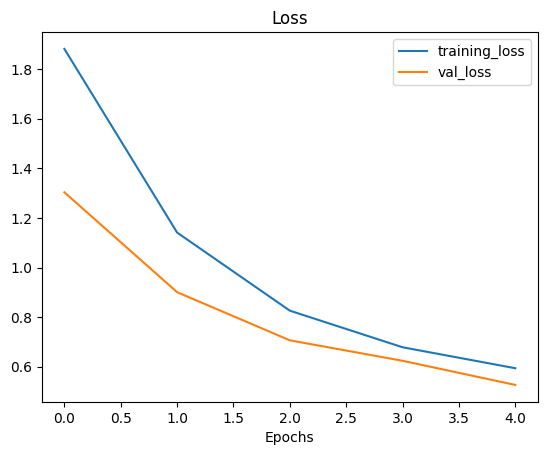

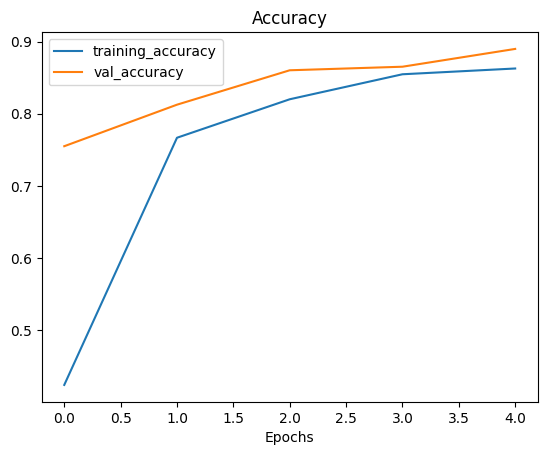

In [13]:
### Check first model's training curves

plot_loss_curves(first_model_history)

Model 2 - Transfer learning (feature extraction) on 1% of the data with data augmentation

In [14]:
### Create data augmentation function

data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
], name = "data_augmentation")

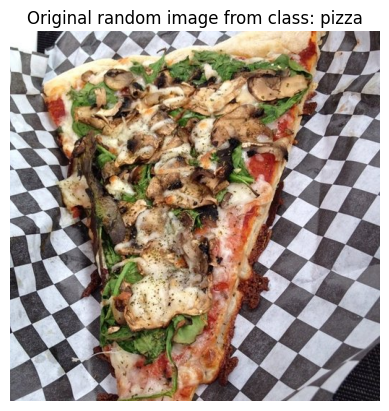

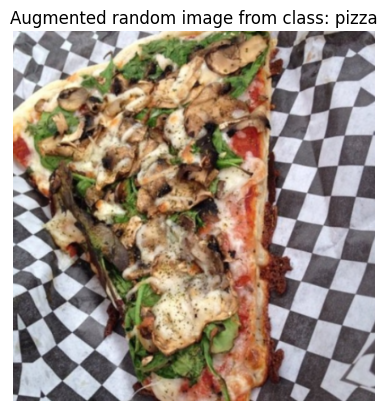

In [15]:
### View original image vs augmented image

random_target_class = random.choice(train_data_1_percent.class_names)
target_dir = "image_data/10_food_classes_1_percent/train/" + random_target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

org_img = mpimg.imread(random_image_path)

plt.imshow(org_img)
plt.title(f"Original random image from class: {random_target_class}")
plt.axis(False);

augmented_img = data_augmentation(tf.expand_dims(org_img, axis = 0))

plt.figure()
plt.imshow(tf.squeeze(augmented_img) / 255.)
plt.title(f"Augmented random image from class: {random_target_class}")
plt.axis(False);

In [16]:
### Second model design

input_shape = (224, 224, 3)

base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

input_layer = layers.Input(shape = input_shape, name = "input_layer")

x = data_augmentation(input_layer)

###  Don't train it during augmentation
x = base_model(x, training = False)

x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)

output_layer = layers.Dense(10, activation = "softmax", name = "output_layer")(x)

second_model = keras.Model(input_layer, output_layer)

second_model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"])

second_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [17]:
second_model_history = second_model.fit(train_data_1_percent, epochs = 5, steps_per_epoch = len(train_data_1_percent),
    validation_data = test_data_1_percent, validation_steps = int(0.25 * len(test_data_1_percent)),
    callbacks = [create_tensorboard_callback("model_log", "1_percent_data_augmentation_feature_extraction")])

Saving TensorBoard log files to: model_log/1_percent_data_augmentation_feature_extraction/20230927-001227
Epoch 1/5
3/3 [==============================] - 23s 8s/step - loss: 2.2939 - accuracy: 0.1143 - val_loss: 2.2092 - val_accuracy: 0.1513
Epoch 2/5
3/3 [==============================] - 16s 7s/step - loss: 2.1054 - accuracy: 0.2429 - val_loss: 2.0675 - val_accuracy: 0.2434
Epoch 3/5
3/3 [==============================] - 15s 7s/step - loss: 1.9334 - accuracy: 0.3857 - val_loss: 1.9660 - val_accuracy: 0.3174
Epoch 4/5
3/3 [==============================] - 15s 7s/step - loss: 1.7754 - accuracy: 0.5000 - val_loss: 1.8692 - val_accuracy: 0.3947
Epoch 5/5
3/3 [==============================] - 15s 7s/step - loss: 1.6818 - accuracy: 0.5000 - val_loss: 1.7830 - val_accuracy: 0.4375


In [18]:
### Evaluation of testing data

second_model.evaluate(test_data_1_percent)

79/79 [==============================] - 56s 703ms/step - loss: 1.8035 - accuracy: 0.4124


[1.8035023212432861, 0.4124000072479248]

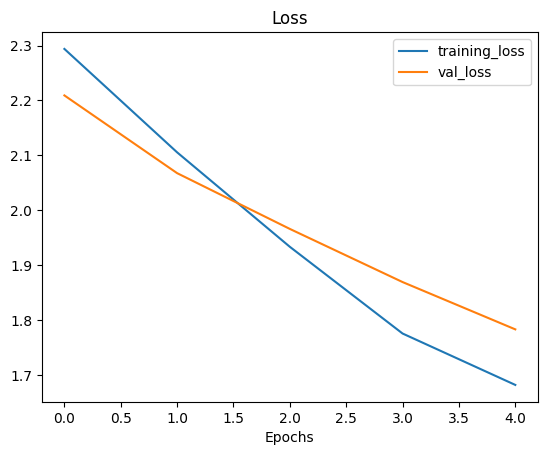

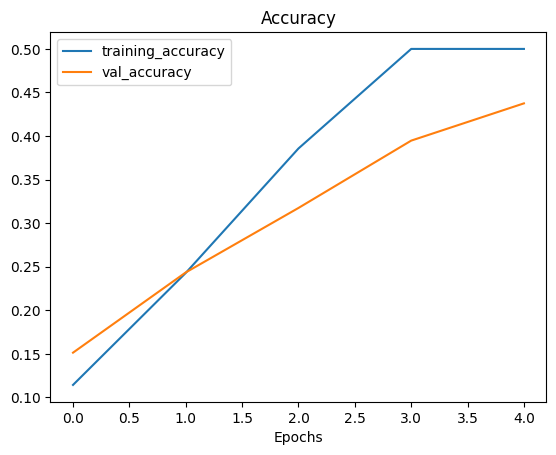

In [19]:
### Plotting of data augmentation layer with only 1% of data

plot_loss_curves(second_model_history)

Model 3 - Transfer learning (feature extraction) on 10% of the data with data augmentation

In [20]:
### Create base model function to save the hassle

def create_base_model(input_shape: tuple[int, int, int] = (224, 224, 3), 
                      output_shape: int = 10, 
                      learning_rate: float = 0.001,
                      training: bool = False) -> tf.keras.Model:
    
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
    base_model.trainable = training
    
    input_layer = layers.Input(shape = input_shape, name = "input_layer")
    
    x = data_augmentation(input_layer)
    x = base_model(x, training = False)
    x = layers.GlobalAveragePooling2D(name = "global_average_pooling_layer")(x)
    
    output_layer = layers.Dense(units = output_shape, activation = "softmax", name = "output_layer")(x)
    
    model = tf.keras.Model(input_layer, output_layer)
    
    model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
        metrics = ["accuracy"])
    
    return model

In [21]:
### Setup checkpoint path
checkpoint_path = "saved_weight/10_percent_data_augmentation_feature_extraction_checkpoint.ckpt"

### Create model checkpoint callback
### Save model weight only, best model weight instead of a model every epoch, save every epoch
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True,
    save_best_only = True, save_freq = "epoch", verbose = 1)     

In [22]:
### Simply clone the second model into third model
### Use learning_rate = 0.001 this time

third_model = tf.keras.models.clone_model(second_model)
third_model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ["accuracy"])

third_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [23]:
### Or use create_base_model for third model

third_model = create_base_model()

third_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [24]:
third_model_history = third_model.fit(train_data_10_percent, epochs = 5,
    validation_data = test_data_10_percent, validation_steps = int(0.25 * len(test_data_10_percent)),
    callbacks = [create_tensorboard_callback("model_log", "10_percent_data_augmentation_feature_extraction"), 
        checkpoint_callback])

Saving TensorBoard log files to: model_log/10_percent_data_augmentation_feature_extraction/20230927-001455
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 1.9518 - accuracy: 0.3627
Epoch 1: val_loss improved from inf to 1.45640, saving model to saved_weight\10_percent_data_augmentation_feature_extraction_checkpoint.ckpt
24/24 [==============================] - 42s 2s/step - loss: 1.9518 - accuracy: 0.3627 - val_loss: 1.4564 - val_accuracy: 0.6826
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3790 - accuracy: 0.6547
Epoch 2: val_loss improved from 1.45640 to 1.04160, saving model to saved_weight\10_percent_data_augmentation_feature_extraction_checkpoint.ckpt
24/24 [==============================] - 36s 2s/step - loss: 1.3790 - accuracy: 0.6547 - val_loss: 1.0416 - val_accuracy: 0.7714
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0742 - accuracy: 0.7480
Epoch 3: val_loss improved from 1.04160 to 0.83337, saving model to sa

In [25]:
### Evaluate on the testing data

third_model_result = third_model.evaluate(test_data_10_percent)

79/79 [==============================] - 57s 720ms/step - loss: 0.6479 - accuracy: 0.8268


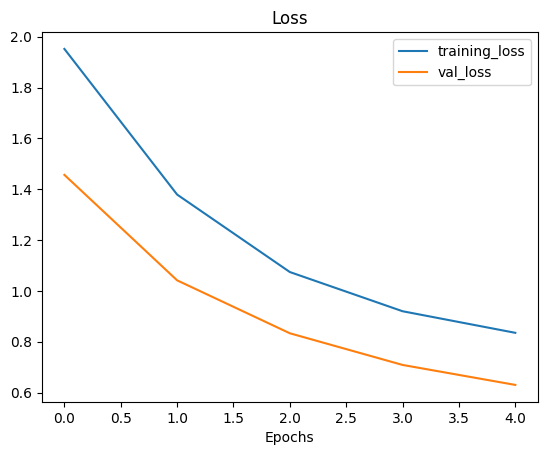

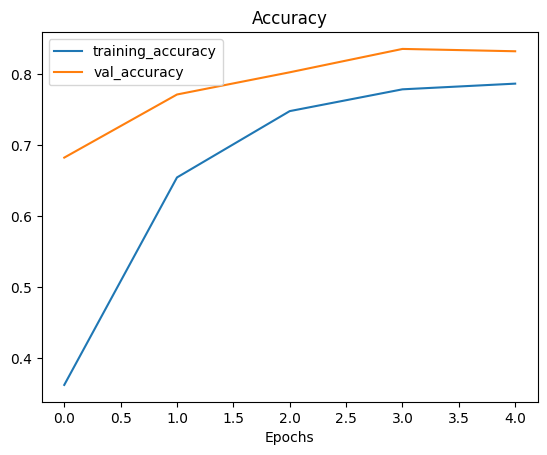

In [26]:
### Check third model's training curves

plot_loss_curves(third_model_history)

Third model's performance with 10% of the data and data augmentation isn't as good as first model with 10% of the data without data augmentation. Based on the chart, the curves are trending in the right direction. If train longer, the metrics would improve.

In [27]:
### Load saved third model weight and perform evaluation
### Comparing previous weight vs check point weight

third_model.load_weights(checkpoint_path)
loaded_weight_model_result = third_model.evaluate(test_data_10_percent)

79/79 [==============================] - 60s 759ms/step - loss: 0.6479 - accuracy: 0.8268


In [28]:
### If the result from third model and the loaded weight are the same, it will output true
### If output false, it means the numbers are close but not the exact same 

third_model_result == loaded_weight_model_result

False

In [29]:
### Other way to check if numbers are close then return true

np.isclose(np.array(third_model_result), np.array(loaded_weight_model_result))

array([ True,  True])

In [30]:
### Check the difference between third model and the loaded weight

np.array(third_model_result) - np.array(loaded_weight_model_result)

array([5.96046448e-08, 0.00000000e+00])

Model 4 - Transfer Learning (Fine-tuning) an third model on 10% of the data

In [31]:
### Check layers in third model

third_model.layers

In [32]:
### Check name, number and trainability

for layer_number, layer in enumerate(third_model.layers):
    print(f"Layer number: {layer_number} | Layer name: {layer.name} | Layer type: {layer} | Trainable? {layer.trainable}")

Layer number: 0 | Layer name: input_layer | Layer type: <keras.src.engine.input_layer.InputLayer object at 0x000002160EAC52B0> | Trainable? True
Layer number: 1 | Layer name: data_augmentation | Layer type: <keras.src.engine.sequential.Sequential object at 0x000002160043DAC0> | Trainable? True
Layer number: 2 | Layer name: efficientnetv2-b0 | Layer type: <keras.src.engine.functional.Functional object at 0x000002160EAD9EB0> | Trainable? False
Layer number: 3 | Layer name: global_average_pooling_layer | Layer type: <keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000002160EAE8130> | Trainable? True
Layer number: 4 | Layer name: output_layer | Layer type: <keras.src.layers.core.dense.Dense object at 0x000002160EB9F4C0> | Trainable? True


In [33]:
### Check summary

third_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [34]:
### Access EfficientNetV2 B0

third_model_base_model = third_model.layers[2]
third_model_base_model.name

'efficientnetv2-b0'

In [35]:
### How many layers are trainable in third_model_base_model

print(len(third_model_base_model.trainable_variables))

0


In [36]:
### Check detail of base model (efficientnetv2-b0)`s layer which trainable

for layer_number, layer in enumerate(third_model_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [37]:
### Fine-tuning last 10 (last 10 are trainable)

### Make all the layers in base model from third model trainable
third_model_base_model.trainable = True

### Freeze all layers except for the last 10
for layer in third_model_base_model.layers[:-10]:
    layer.trainable = False

### This time set learning rrate 10x lower than previous for fine-tuning
third_model.compile(loss = "categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
    metrics = ["accuracy"])

In [38]:
### Check which layers are trainable

for layer_number, layer in enumerate(third_model_base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [39]:
### Check which layers are trainable second example
### Guess third_model_base_model already refer and modify it

for layer_number, layer in enumerate(third_model.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 

In [40]:
### Check How many trainable variables
### Total 12 trainable variables include last 10 layers of the base model, weight and bias

print(len(third_model.trainable_variables))

12


In [41]:
# Setup new checkpoint path

checkpoint_path = "saved_weight/10_percent_data_augmentation_fine_tuning_checkpoint.ckpt"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True,
    save_best_only = True, save_freq = "epoch", verbose = 1)  

In [42]:
### Add more 5 epochs to initial epochs

third_model_2_history = third_model.fit(train_data_10_percent, epochs = 10,
    validation_data = test_data_10_percent, validation_steps = int(0.25 * len(test_data_10_percent)),
    callbacks = [create_tensorboard_callback("model_log", "10_percent_data_augmentation_fine_tuning"), checkpoint_callback])

Saving TensorBoard log files to: model_log/10_percent_data_augmentation_fine_tuning/20230927-001957
Epoch 1/10
24/24 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.8040
Epoch 1: val_loss improved from inf to 0.48686, saving model to saved_weight\10_percent_data_augmentation_fine_tuning_checkpoint.ckpt
24/24 [==============================] - 44s 2s/step - loss: 0.7013 - accuracy: 0.8040 - val_loss: 0.4869 - val_accuracy: 0.8421
Epoch 2/10
24/24 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.8307
Epoch 2: val_loss improved from 0.48686 to 0.46702, saving model to saved_weight\10_percent_data_augmentation_fine_tuning_checkpoint.ckpt
24/24 [==============================] - 37s 2s/step - loss: 0.5898 - accuracy: 0.8307 - val_loss: 0.4670 - val_accuracy: 0.8520
Epoch 3/10
24/24 [==============================] - ETA: 0s - loss: 0.5399 - accuracy: 0.8413
Epoch 3: val_loss improved from 0.46702 to 0.42996, saving model to saved_weight\10_perc

In [43]:
### Evaluate fine-tuning third model on the test data

third_model_2_result = third_model.evaluate(test_data_10_percent)

79/79 [==============================] - 57s 714ms/step - loss: 0.4247 - accuracy: 0.8588


In [44]:
### Create compare history function

def compare_history(original_history, new_history, initial_epochs = 5):
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize = (8, 8))
    
    plt.subplot(2, 1, 1)
    
    plt.plot(total_acc, label = 'Training Accuracy')
    plt.plot(total_val_acc, label = 'Validation Accuracy')
    plt.plot([initial_epochs - 1, initial_epochs - 1],
              plt.ylim(), label = 'Start Fine Tuning')
    plt.legend(loc = 'lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    
    plt.plot(total_loss, label = 'Training Loss')
    plt.plot(total_val_loss, label = 'Validation Loss')
    plt.plot([initial_epochs - 1, initial_epochs - 1],
              plt.ylim(), label = 'Start Fine Tuning')
    plt.legend(loc = 'upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    
    plt.show()

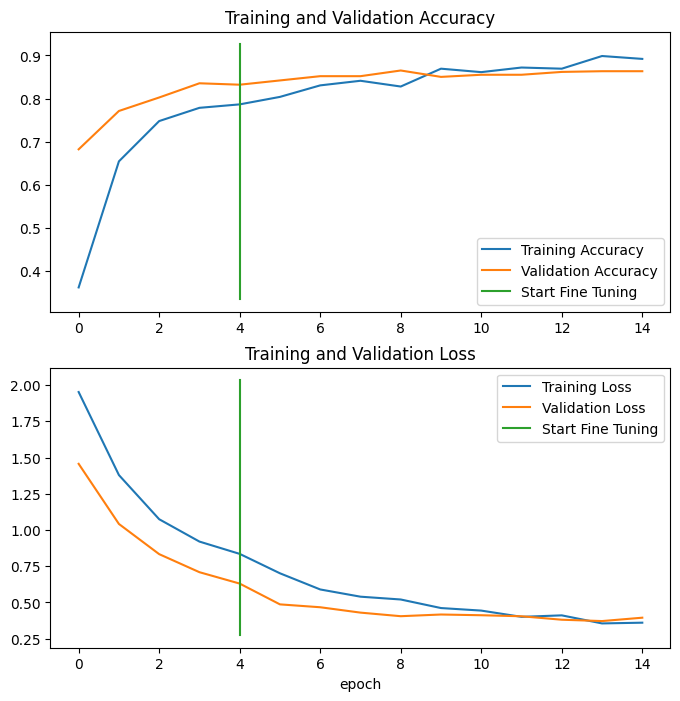

In [45]:
compare_history(original_history = third_model_history , new_history = third_model_2_history, 
    initial_epochs = 5)